In [63]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Flatten, Dense, LSTM, \
    MaxPooling2D
from keras.models import Sequential
from common import extract_training_data_in_overlapping_groups

IMAGE_SIZE = (32, 32, 3)

In [64]:
images, labels = extract_training_data_in_overlapping_groups("Data/20171029-201949.h264.avi", "Data/20171029-201949.h264.csv", IMAGE_SIZE)

In [65]:
y_train = labels[:, :, 1: -1]
y_train.shape

(1741, 4, 3)

In [66]:
images.shape

(1741, 4, 32, 32, 3)

In [67]:
from keras.layers import Permute, Reshape, TimeDistributed

def create_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(None, 32, 32, 3)))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32, return_sequences=True))
    model.add(TimeDistributed(Dense(3)))
    
    model.compile(loss="mse", optimizer="adam")
    
    return model

model = create_model()
model.summary()

AssertionError: 

In [50]:
history = model.fit(images, y_train, batch_size=64, epochs=10, validation_split=0.04)

Train on 1671 samples, validate on 70 samples
Epoch 1/10
1671/1671 [==============================] - 2s - loss: 0.1515 - val_loss: 0.2760
Epoch 2/10
1671/1671 [==============================] - 0s - loss: 0.0959 - val_loss: 0.3049
Epoch 3/10
1671/1671 [==============================] - 0s - loss: 0.0727 - val_loss: 0.3055
Epoch 4/10
1671/1671 [==============================] - 0s - loss: 0.0585 - val_loss: 0.3104
Epoch 5/10
1671/1671 [==============================] - 0s - loss: 0.0545 - val_loss: 0.2902
Epoch 6/10
1671/1671 [==============================] - 0s - loss: 0.0469 - val_loss: 0.3122
Epoch 7/10
1671/1671 [==============================] - 0s - loss: 0.0459 - val_loss: 0.2631
Epoch 8/10
1671/1671 [==============================] - 0s - loss: 0.0426 - val_loss: 0.3011
Epoch 9/10
1671/1671 [==============================] - 0s - loss: 0.0394 - val_loss: 0.2689
Epoch 10/10
1671/1671 [==============================] - 0s - loss: 0.0402 - val_loss: 0.2516


In [51]:
test_images, test_labels = extract_training_data_in_overlapping_groups("Data/20171029-201639.h264.avi", 
                                                            "Data/20171029-201639.h264.csv", 
                                                            IMAGE_SIZE)
test_labels = test_labels[:, :, 1: -1]

prediction = model.predict(test_images)

In [52]:
prediction.shape

(939, 4, 3)

In [53]:
prediction = prediction[:, -1, :]
prediction.shape

(939, 3)

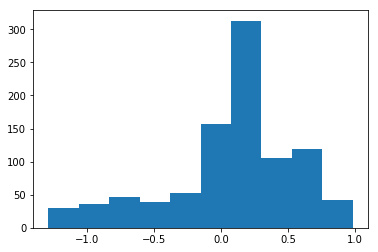

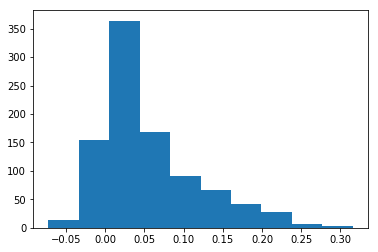

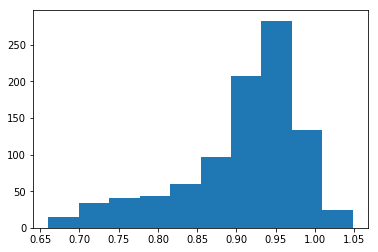

In [54]:
plt.hist(prediction[:, 0])
plt.show()

plt.hist(prediction[:, 1])
plt.show()

plt.hist(prediction[:, 2])
plt.show()

In [55]:
clipped_prediction = np.zeros_like(prediction)

clipped_prediction[:, 0] = np.clip(prediction[:, 0], -1, 1)
clipped_prediction[:, 1] = np.clip(prediction[:, 1], 0, 1)
clipped_prediction[:, 2] = np.clip(prediction[:, 2], 0, 1)

prediction_test_labels = test_labels[:, -1, :]

print(prediction_test_labels.shape)
print(clipped_prediction.shape)

(939, 3)
(939, 3)


In [57]:
from sklearn.metrics import explained_variance_score
explained_variance_score(prediction_test_labels, prediction)

0.15544802094451615

In [62]:
from common import run_kfold_cross_val

# Concatenate both videos
total_images = np.concatenate((images, test_images), axis=0)
total_labels = np.concatenate((y_train, test_labels), axis=0)

results = run_kfold_cross_val(create_model, total_images, total_labels)
print(results)
print(results.mean())
print(np.median(results))

(2680, 4, 3)


ValueError: Found array with dim 3. Estimator expected <= 2.